# 26. Long-term cycle
This notebook investigates evidence for eccentricity paced variability in bottom water oxygen and potential driving mechanisms for that using 
* a compilation of sapropels from mediterrainean sea ODP sites from [Emeis et al. (2000) "The sapropel record of the eastern Mediterranean Sea — results of Ocean Drilling Program Leg 160"](https://www.sciencedirect.com/science/article/pii/S0031018200000596?casa_token=Dl_eE6nssPkAAAAA:34am_RV6f4KsLMz8rBb1NM95HqOCjGzxjsjzHnfi7M6IIQ8jK_Sd-gLueTDDk7EVsEZ9Q2QAew)
* alkenone data from ODP 1090 from [Martinez-Garcia et al. (2011), "Southern Ocean dust–climate coupling over the past four million years"](https://idp.nature.com/authorize/casa?redirect_uri=https://www.nature.com/articles/nature10310&casa_token=d7GwM3gF-QIAAAAA:xbHNbUJrb2XP88zz7jeQEzidOx70YNu9fuPLZoM2zshizxrCCL5XxosXihuznvAs_JcLLFCzj9K-Jpg_sQ)

This code generates Figure 5 from the main text.
## Setup
### Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

### Set paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
core_photos='/Users/danielbabin/GitHub/Green_Bands/CorePhotos/LowRes/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'
misc_path='/Users/danielbabin/GitHub/Green_Bands/Data/Misc/'
checkpoints_path='/Users/danielbabin/GitHub/Green_Bands/Data/Checkpoints/'

### Import data
#### Glacials

In [3]:
glacials=[[14, 29],[57, 71],[130, 191],[243, 300],[337, 374],[424, 478],[524, 563],[621, 676],
          [712, 761],[790, 814],[866, 900],[917, 936],[959, 970],[982, 1014],[1031, 1062],[1081,1104],
          [1114, 1141],[1190,1215],[1240,1265],[1285,1300]]

#### Benthic Carbon

In [4]:
globl=pd.read_csv(table_path+'Supplementary Table 7 - Global benthic d13C stack.csv',index_col='Age [ka BP]')

#### ODP 1090
##### Dust record

In [5]:
femar=pd.read_csv(misc_path+'1090-Fe-Dust-MAR-martinez-garcia.csv')
femar=femar.drop(0).dropna(how='all',axis=1)
femar=femar.astype(float)
femar=femar.set_index('Age').sort_index().dropna()

##### Productivity record

In [6]:
alkmar=pd.read_csv(misc_path+'1090-n-alkanes MAR-martinez-garcia.csv')
alkmar=alkmar.drop(0)
alkmar=alkmar.astype(float)
alkmar=alkmar.set_index('Age').sort_index().dropna()

#### Green Bands

In [7]:
green_layers_U1474=pd.read_csv(table_path+'Supplementary Table 6A - U1474 green bands.csv')
green_layers_1313=pd.read_csv(table_path+'Supplementary Table 6B - U1313 green bands.csv')

In [8]:
green_true_U1474=green_layers_U1474.copy()

green_layers_1313['Class']=green_layers_1313['Label']-1
green_true_1313=green_layers_1313[green_layers_1313['Class']>0].copy()

##### Age Model

In [9]:
amU1474=pd.read_csv(table_path+'Supplementary Table 2 - Age-depth model.csv')
amU1474['Top Interval Depth CCSF (m)']=amU1474['Depth CCSF (m)'].shift(1)
amU1474['Top Interval Age (kyr)']=amU1474['Age (ka BP)'].shift(1)
famU1474=interpolate.interp1d(amU1474['Depth CCSF (m)'],amU1474['Age (ka BP)'],bounds_error=False)

In [10]:
am1313=pd.read_csv(misc_path+'1313_age_model_L*.csv')
fam1313=interpolate.interp1d(am1313['Depth (mcd)'],am1313['Age (ka)'],bounds_error=False)

In [11]:
green_true_U1474['Top Age (kyr)']=famU1474(green_true_U1474['Top Depth CCSF (m)'])
green_true_U1474['Bottom Age (kyr)']=famU1474(green_true_U1474['Bottom Depth CCSF (m)'])
agtU1474=green_true_U1474[~green_true_U1474['Top Age (kyr)'].isnull()].set_index('Top Age (kyr)').sort_index()

In [12]:
green_true_1313['Top Age (kyr)']=fam1313(green_true_1313['Top Depth CCSF (m)'])
green_true_1313['Bottom Age (kyr)']=fam1313(green_true_1313['Bottom Depth CCSF (m)'])
agt1313=green_true_1313[~green_true_1313['Top Age (kyr)'].isnull()].set_index('Top Age (kyr)').sort_index()

##### Create abundance record

In [13]:
step=1
bin_edges=np.arange(0,1200+step,step,dtype=int)

In [14]:
col_list=['U1474','U1474_C2+', 'U1474_C3', 
          '1313', '1313_C2+', '1313_C3']

In [15]:
records=pd.DataFrame(0.0,index=bin_edges,columns=col_list)
number_records=pd.DataFrame(0.0,index=bin_edges,columns=col_list)
for i,site in enumerate([agtU1474.loc[0:1200].copy(),agt1313.loc[0:1200].copy()]):
# for i,site in enumerate([agtU1474,agt1313,agt659,agt1143,agt758,agtU1489]):
    sitename=site['Site'].iloc[0]
    nearest=np.round(site.index/step)*step
    site['Nearest']=nearest
    
    thicknesses_total=site.groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    thicknesses_c2_plus=site[site['Class']>1].groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    thicknesses_c3=site[site['Class']==3].groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    records.loc[thicknesses_total.index,str(sitename)]=thicknesses_total.values
    records.loc[thicknesses_c2_plus.index,str(sitename)+'_C2+']=thicknesses_c2_plus.values
    records.loc[thicknesses_c3.index,str(sitename)+'_C3']=thicknesses_c3.values

    number_total=site.groupby('Nearest').count().iloc[:,0]
    number_c2_plus=site[site['Class']>1].groupby('Nearest').count().iloc[:,0]
    number_c3=site[site['Class']==3].groupby('Nearest').count().iloc[:,0]
    number_records.loc[number_total.index,str(sitename)]=number_total.values
    number_records.loc[number_c2_plus.index,str(sitename)+'_C2+']=number_c2_plus.values
    number_records.loc[number_c3.index,str(sitename)+'_C3']=number_c3.values

##### Green band stack

In [16]:
gl_stack=pd.DataFrame(index=records.index)
gl_stack['U1474']=records['U1474']
gl_stack['1313']=records['1313']
n=5
gl_stack_5ka=gl_stack.rolling(n).sum().iloc[::n] ## 5 ky
gl_stack_5ka=gl_stack_5ka.round(2) ## weird i need to round
tf_gl_stack_5ka=(gl_stack_5ka>0).astype(int)
gl_stack_5ka=gl_stack_5ka.rename(columns={'U1474':'U1474 Thickness','1313':'1313 Thickness'})
tf_gl_stack_5ka=tf_gl_stack_5ka.rename(columns={'U1474':'U1474 True','1313':'1313 True'})
gl_stack=tf_gl_stack_5ka.sum(axis=1)
gl_stack=gl_stack.to_frame(name='n sites')
gl_stack['thickness']=gl_stack_5ka.sum(axis=1)/2
gl_stack=pd.concat([gl_stack,gl_stack_5ka,tf_gl_stack_5ka],axis=1)
gl_stack['U1474 True']=gl_stack['U1474 True'].astype(bool)
gl_stack['1313 True']=gl_stack['1313 True'].astype(bool)

In [17]:
sync=gl_stack[gl_stack['n sites']==2].loc[0:1200].copy()

#### Sapropels

In [18]:
saps_all=pd.read_csv(misc_path+'mediterranean_sapropels.csv')
saps_all['Age (kyr)']=saps_all['Age (Ma) with 3\xa0ky lag']*1000
saps_all=saps_all[(saps_all['Age (Ma) with 3\xa0ky lag']<2)].copy()
saps_all=saps_all[(saps_all['Site']==964)|(saps_all['Site']==966)|(saps_all['Site']==967)|(saps_all['Site']==969)].copy()

saps=saps_all[(saps_all['Type']=='SAP')&(saps_all['Age (kyr)']<1200)].copy()
ghosts=saps_all[(saps_all['Type']=='GHOST')|(saps_all['Type']=='GHOST?')].copy()
ghosts=ghosts[ghosts['Age (kyr)']<1200].copy()
reds=saps_all[(saps_all['Type']=='RED INTERVALS')&(saps_all['Age (kyr)']<1200)].copy()

saps=saps.set_index('Age (kyr)').sort_index()
ghosts=ghosts.set_index('Age (kyr)').sort_index()
reds=reds.set_index('Age (kyr)').sort_index()

ghosts_and_reds=pd.concat([ghosts,reds]).sort_index()

##### Create sapropel abundance record

In [19]:
step=1
bin_edges=np.arange(0,1200+step,step,dtype=int)

In [20]:
records_sap=pd.DataFrame(0.0,index=bin_edges,columns=['Sapropel','Ghost','Red','Ghosts and Reds'])
kinds=['Sapropel','Ghost','Red','Ghosts and Reds']
for i,site in enumerate([saps,ghosts,reds,ghosts_and_reds]):
    kind=kinds[i]
    nearest=np.round(site.index/step)*step
    site['Nearest']=nearest
    
    thicknesses_total=site.groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    records_sap.loc[thicknesses_total.index,str(kind)]=thicknesses_total.values

## N events per stage

In [21]:
depths_MIS=pd.read_csv(checkpoints_path+'U1474 Marine Isotope Stage Depths.csv',index_col='MIS')

In [22]:
depths_MIS_no234=depths_MIS.copy()

In [23]:
depths_MIS_no234.loc[2,['Bottom Depth (m)','Bottom Age (kyr)']]=depths_MIS_no234.loc[5,['Top Depth (m)',
                                                                                        'Top Age (kyr)']].values
depths_MIS_no234=depths_MIS_no234.drop([3,4])

In [24]:
depths_MIS_no234.loc[2,'Duration (kyr)']=(depths_MIS_no234.loc[2,'Bottom Age (kyr)']-
                                          depths_MIS_no234.loc[2,'Top Age (kyr)'])
depths_MIS_no234.loc[2,'Thickness (cm)']=(depths_MIS_no234.loc[2,'Bottom Depth (m)']-
                                          depths_MIS_no234.loc[2,'Top Depth (m)'])*100
depths_MIS_no234.loc[2,'Sedimentation Rate (cm/kyr)']=(depths_MIS_no234.loc[2,'Thickness (cm)']/
                                                       depths_MIS_no234.loc[2,'Duration (kyr)'])

### Green Bands

In [25]:
green_per=pd.DataFrame(index=depths_MIS_no234.index)
for i,mis in enumerate(depths_MIS_no234.index):
    start=depths_MIS_no234.loc[mis,'Bottom Age (kyr)']
    end=depths_MIS_no234.loc[mis,'Top Age (kyr)']
    duration=depths_MIS_no234.loc[mis,'Duration (kyr)']
    
    slc=sync.loc[end:start]
    
    ### thickness and numbers
    green_per.loc[mis,'sync n']=slc.shape[0]
    green_per.loc[mis,'sync n/kyr']=(green_per.loc[mis,'sync n']/duration)
    green_per.loc[mis,'sync Thickness']=slc['thickness'].sum()
    green_per.loc[mis,'sync Thickness/kyr']=green_per.loc[mis,'sync Thickness']/duration

for i,mis in enumerate(depths_MIS_no234.index):
    start=depths_MIS_no234.loc[mis,'Bottom Age (kyr)']
    end=depths_MIS_no234.loc[mis,'Top Age (kyr)']
    duration=depths_MIS_no234.loc[mis,'Duration (kyr)']
    
    slc=agtU1474.loc[end:start]
    
    ### thickness and numbers
    green_per.loc[mis,'U1474 n']=slc.shape[0]
    green_per.loc[mis,'U1474 n/kyr']=(green_per.loc[mis,'U1474 n']/duration)
    green_per.loc[mis,'U1474 Thickness']=slc['Thickness (cm)'].sum()
    green_per.loc[mis,'U1474 Thickness/kyr']=green_per.loc[mis,'U1474 Thickness']/duration

for i,mis in enumerate(depths_MIS_no234.index):
    start=depths_MIS_no234.loc[mis,'Bottom Age (kyr)']
    end=depths_MIS_no234.loc[mis,'Top Age (kyr)']
    duration=depths_MIS_no234.loc[mis,'Duration (kyr)']
    
    slc=agt1313.loc[end:start]
    
    ### thickness and numbers
    green_per.loc[mis,'1313 n']=slc.shape[0]
    green_per.loc[mis,'1313 n/kyr']=(green_per.loc[mis,'1313 n']/duration)
    # green_per.loc[mis,'Thickness (cm)']=slc['thickness'].sum()
    green_per.loc[mis,'1313 Thickness']=slc['Thickness (cm)'].sum()
    green_per.loc[mis,'1313 Thickness/kyr']=green_per.loc[mis,'1313 Thickness']/duration

green_per['both n']=green_per['U1474 n']+green_per['1313 n']
green_per['both n/kyr']=green_per['U1474 n/kyr']+green_per['1313 n/kyr']
green_per['both Thickness']=green_per['U1474 Thickness']+green_per['1313 Thickness']
green_per['both Thickness/kyr']=green_per['U1474 Thickness/kyr']+green_per['1313 Thickness/kyr']


### Ages
col_list=['Top Age (kyr)','Bottom Age (kyr)','Duration (kyr)']
green_per[col_list]=depths_MIS_no234[col_list]

### Sapropels

In [26]:
reds_per=pd.DataFrame(index=depths_MIS_no234.index)
for i,mis in enumerate(depths_MIS_no234.index):
    start=depths_MIS_no234.loc[mis,'Bottom Age (kyr)']
    end=depths_MIS_no234.loc[mis,'Top Age (kyr)']
    duration=depths_MIS_no234.loc[mis,'Duration (kyr)']
    
    slc=reds.loc[end:start]
    
    ### thickness and numbers
    reds_per.loc[mis,'reds n']=slc.shape[0]
    reds_per.loc[mis,'reds n/kyr']=(reds_per.loc[mis,'reds n']/duration)
    reds_per.loc[mis,'reds Thickness']=slc['Thickness (cm)'].sum()
    reds_per.loc[mis,'reds Thickness/kyr']=reds_per.loc[mis,'reds Thickness']/duration

ghosts_per=pd.DataFrame(index=depths_MIS_no234.index)
for i,mis in enumerate(depths_MIS_no234.index):
    start=depths_MIS_no234.loc[mis,'Bottom Age (kyr)']
    end=depths_MIS_no234.loc[mis,'Top Age (kyr)']
    duration=depths_MIS_no234.loc[mis,'Duration (kyr)']
    
    slc=ghosts.loc[end:start]
    
    ### thickness and numbers
    ghosts_per.loc[mis,'ghosts n']=slc.shape[0]
    ghosts_per.loc[mis,'ghosts n/kyr']=(ghosts_per.loc[mis,'ghosts n']/duration)
    ghosts_per.loc[mis,'ghosts Thickness']=slc['Thickness (cm)'].sum()
    ghosts_per.loc[mis,'ghosts Thickness/kyr']=ghosts_per.loc[mis,'ghosts Thickness']/duration

saps_per=pd.DataFrame(index=depths_MIS_no234.index)
for i,mis in enumerate(depths_MIS_no234.index):
    start=depths_MIS_no234.loc[mis,'Bottom Age (kyr)']
    end=depths_MIS_no234.loc[mis,'Top Age (kyr)']
    duration=depths_MIS_no234.loc[mis,'Duration (kyr)']
    
    slc=saps.loc[end:start]
    
    ### thickness and numbers
    saps_per.loc[mis,'saps n']=slc.shape[0]
    saps_per.loc[mis,'saps n/kyr']=(saps_per.loc[mis,'saps n']/duration)
    saps_per.loc[mis,'saps Thickness']=slc['Thickness (cm)'].sum()
    saps_per.loc[mis,'saps Thickness/kyr']=saps_per.loc[mis,'saps Thickness']/duration

saps_per=pd.concat([saps_per,reds_per,ghosts_per],axis=1)

### Ages
col_list=['Top Age (kyr)','Bottom Age (kyr)','Duration (kyr)']
saps_per[col_list]=depths_MIS_no234[col_list]
saps_per['reds+ghosts n']=saps_per['ghosts n']+saps_per['reds n']

## Green bands, sapropels, southern ocean dust, carbon cycle

In [27]:
insol30s=pd.read_csv(misc_path+'insolation30N.txt',sep='\s',
                  header=None,engine='python',names=['Age (kyr)','insolation']).astype(float)
insol30s=insol30s.set_index('Age (kyr)')
insol30s['insolation']=(insol30s['insolation']-insol30s['insolation'].mean())*-1+insol30s['insolation'].mean()

In [28]:
pad_width=20
lpfilt=signal.butter(1,[1/(400+pad_width),1/(400-pad_width)],btype='band',analog=False,output='sos')
filtered=signal.sosfiltfilt(lpfilt,insol30s['insolation'])
insol30s['400kyr']=filtered

In [29]:
paired=sns.color_palette('tab20c')
paired

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [30]:
colorblind=sns.color_palette('colorblind')
colorblind[2]

(0.00784313725490196, 0.6196078431372549, 0.45098039215686275)

In [31]:
alpha=1

/var/folders/5g/c_zltr_s4ws8lr9yxmzvqv3r0000gn/T/ipykernel_8874/1029968492.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


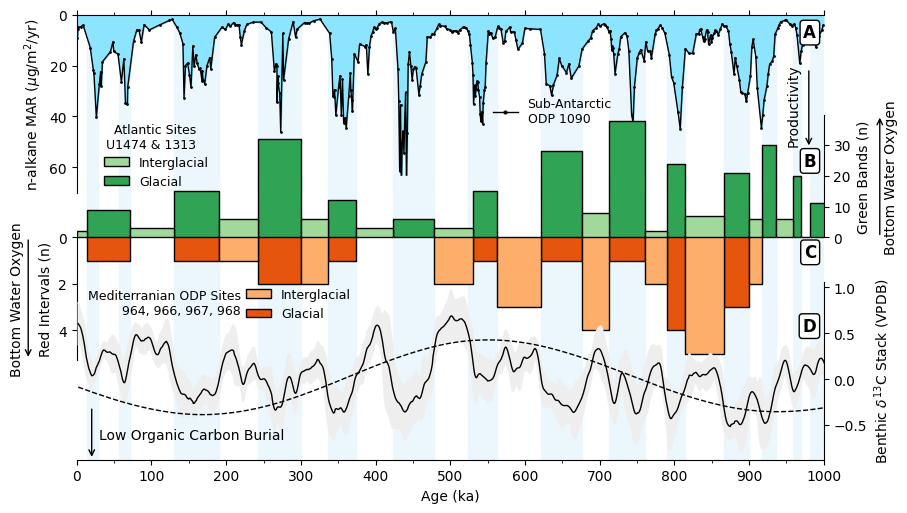

In [32]:
fig=plt.figure(figsize=(9,5),facecolor='w')
gs = gridspec.GridSpec(11, 1, figure=fig,hspace=-.7,top=.98,bottom=.09,right=.91,left=.08)
gsA = gs[:3].subgridspec(1, 1)
gsB = gs[3:8].subgridspec(2, 1,hspace=0)
gsC = gs[8:].subgridspec(1, 1)

ax0 = fig.add_subplot(gsA[0])
ax1 = fig.add_subplot(gsB[0])
ax2 = fig.add_subplot(gsB[1])
ax3 = fig.add_subplot(gsC[0])
axes=[ax0,ax1,ax2,ax3]

sns.despine(ax=axes[0],bottom=True,top=False,right=True)
sns.despine(ax=axes[1],bottom=True,top=True,right=False,left=True)
sns.despine(ax=axes[2],bottom=True,top=True,right=True)
sns.despine(ax=axes[3],bottom=False,top=True,right=False,left=True)

sec0=axes[0].twinx()
sec0.axis('off')
sns.despine(ax=sec0,top=True,bottom=True)

for ax in axes:
    ax.patch.set_visible(False)
for ax in axes[1:-1]:
    ax.xaxis.set_visible(False)
for ax in [axes[1],axes[3]]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

ymaxes=[.99,.5,.99,.57]       
for i,ax in enumerate(axes):
    for g in glacials:
        start=g[0]
        end=g[1]
        ax.axvspan(xmin=start,xmax=end,ymax=ymaxes[i],zorder=-10,color='#ebf7fc')

######################################################################################## Alkanes
ax=axes[0]
ax.fill_between(x=alkmar.loc[0:1000].index,y1=0,y2=alkmar['n-alkanes MAR'].loc[0:1000],color='#8DE4FF')
# ax.fill_between(x=alkmar.loc[0:1000].index,y1=0,y2=alkmar['n-alkanes MAR'].loc[0:1000],color=paired[3])
alkmar['n-alkanes MAR'].loc[0:1000].plot(ax=ax,color='k',marker='o',ms=1,lw=1)
ax.invert_yaxis()

ax.set_xlim(0,1000)
ax.set_ylabel('n-alkane MAR ($\mu$g/m$^2$/yr)')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylim(70,0)

custom_lines = [Line2D([0], [0], color='k', lw=1, marker='o',ms=2)]
legend=ax.legend(custom_lines, ['Sub-Antarctic\nODP 1090'],loc=(.55,.35),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))

ax.annotate('',xy=(.98,.7),xytext=(.98,.25),ha='center',va='top',xycoords='axes fraction',
            arrowprops=dict(arrowstyle="<-"),rotation=90,fontweight='bold')
ax.annotate('Productivity',xy=(.96,(.7+.25)/2+.02),ha='center',va='center',xycoords='axes fraction',rotation=90)

########################################################################################
ax=axes[1]
gsed=green_per[green_per.index%2==0]
igsed=green_per[green_per.index%2==1]

col='both n'
# col='n/per kyr'
# col='Thickness (cm)'
# col='Thickness per kyr'
ax.bar(gsed['Top Age (kyr)'],gsed[col],gsed['Duration (kyr)'],
       align='edge',label='Glacial',alpha=alpha,ec='k',
       color=paired[8])#'#3CB371')
ax.bar(igsed['Top Age (kyr)'],igsed[col],igsed['Duration (kyr)'],
       align='edge',label='Interglacial',alpha=alpha,ec='k',
       color=paired[10])#'#9ACD32')

ax.set_xlim(0,1000)
ax.set_ylabel('Green Bands (n)')

custom_lines = [Patch(color=paired[10], ec='k'),
                Patch(color=paired[8], ec='k')]
legend=ax.legend(custom_lines, ['Interglacial','Glacial'],loc=(.03,.36),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))
ax.annotate('Atlantic Sites\nU1474 & 1313',xy=(.16,.7),xycoords='axes fraction',va='bottom',ha='right',fontsize=9)
ax.annotate('',xy=(1.075,0),xytext=(1.075,1),ha='center',va='top',xycoords='axes fraction',
            arrowprops=dict(arrowstyle="<-"),rotation=90,fontweight='bold')
ax.annotate('Bottom Water Oxygen',xy=(1.09,(.7+.25)/2+.02),ha='center',va='center',xycoords='axes fraction',rotation=90)

########################################################################################

ax=axes[2]
gsed=saps_per[saps_per.index%2==0]
igsed=saps_per[saps_per.index%2==1]

col='reds n'
# col='n/per kyr'
# col='Thickness (cm)'
# col='Thickness per kyr'
ax.bar(gsed['Top Age (kyr)'],gsed[col],gsed['Duration (kyr)'],
       align='edge',label='Glacial',alpha=alpha,ec='k',
       color=paired[4])#'#C71585')
ax.bar(igsed['Top Age (kyr)'],igsed[col],igsed['Duration (kyr)'],
       align='edge',label='Interglacial',alpha=alpha,ec='k',
       color=paired[6])#'#E9573F')
ax.invert_yaxis()

ax.set_xlim(0,1000)
ax.set_ylabel('Red Intervals (n)')

custom_lines = [Patch(color=paired[6], ec='k'),
                Patch(color=paired[4], ec='k')]
legend=ax.legend(custom_lines, ['Interglacial','Glacial'],loc=(.22,.28),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))
ax.annotate('Mediterranian ODP Sites\n964, 966, 967, 968',xy=(.22,.35),xycoords='axes fraction',va='bottom',ha='right',fontsize=9)

ax.annotate('',xy=(-.065,1),xytext=(-.065,0),ha='center',va='top',xycoords='axes fraction',
            arrowprops=dict(arrowstyle="<-"),rotation=90,fontweight='bold')
ax.annotate('Bottom Water Oxygen',xy=(-.08,(.7+.25)/2+.02),ha='center',va='center',xycoords='axes fraction',rotation=90)

########################################################################################
ax=axes[3]
benthxs=globl['stack'].index
benthys=globl['stack']
benth_plus_s=globl['stack']+globl['1s']
benth_minus_s=globl['stack']-globl['1s']
ax.fill_between(x=benthxs,y1=benth_minus_s,y2=benth_plus_s,color='#eeeeee')
ax.plot(benthxs,benthys,lw=1,color='k')
# ax.invert_yaxis()
ax.set_ylabel('Benthic $\delta^{13}$C Stack (VPDB)')
ax.set_xlabel('Age (ka)')

sec=ax.twinx()
sec.axis('off')
# sec.invert_yaxis()
sec.plot(globl['filt'].index,globl['filt'].values,color='k',lw=1,ls='--')
sec.set_ylim(.1133,.1143)
# ax.yaxis.tick_right()

ax.set_yticks([-.5,0,.5,1])
ax.yaxis.tick_right()

ax.annotate('',xy=(.02,.3),xytext=(.02,0),ha='center',va='top',xycoords='axes fraction',
            arrowprops=dict(arrowstyle="<-"),rotation=90,fontweight='bold')
ax.annotate('Low Organic Carbon Burial',xy=(.03,.14),ha='left',va='center',xycoords='axes fraction')

ax.set_xlim(0,1000)
for ax in [axes[0],axes[-1]]:
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))

letters=['A','C']
for n,ax in enumerate([axes[0],axes[2]]):
    ax.annotate(letters[n],xy=(.99,.95),xycoords='axes fraction',ha='right',va='top',fontsize=12,fontweight='bold',
                bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
axes[1].annotate('B',xy=(.99,.55),xycoords='axes fraction',ha='right',va='bottom',fontsize=12,fontweight='bold',
            bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
axes[3].annotate('D',xy=(.99,.7),xycoords='axes fraction',ha='right',va='bottom',fontsize=12,fontweight='bold',
            bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

plt.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig(figure_path+'Figure 5 - Long term cycle.png',dpi=300)

# Frequency analysis

In [33]:
dfs=[alkmar,green_per,saps_per,globl]

In [34]:
green_per['Middle Age (kyr)']=(green_per['Top Age (kyr)']+green_per['Bottom Age (kyr)'])/2
saps_per['Middle Age (kyr)']=(saps_per['Top Age (kyr)']+saps_per['Bottom Age (kyr)'])/2

In [35]:
import pyleoclim as pyleo

In [90]:
alkts = pyleo.Series(time=alkmar.loc[0:1200].index,value=alkmar.loc[0:1200,'n-alkanes MAR'],
                    time_name='Age',time_unit='kyr BP',value_name='n-alkanes MAR',value_unit='ug/m2/yr',
                    label='ODP 1090')
gts = pyleo.Series(time=green_per['Middle Age (kyr)'],value=green_per['sync n'],
                    time_name='Age',time_unit='kyr BP',value_name='green bands',value_unit='n',
                    label='IODP U1474 and U1313')
gtsU1474 = pyleo.Series(time=records.index,value=number_records['U1474'],
                        time_name='Age',time_unit='kyr BP',value_name='green bands',value_unit='n',
                        label='IODP U1474 Green Band Thickness')
gtsU1313 = pyleo.Series(time=records.index,value=number_records['1313'],
                        time_name='Age',time_unit='kyr BP',value_name='green bands',value_unit='n',
                        label='IODP U1313')
rts = pyleo.Series(time=saps_per['Middle Age (kyr)'],value=saps_per['reds n'],
                    time_name='Age',time_unit='kyr BP',value_name='red intervals',value_unit='n',
                    label='ODP 964, 966, 967, 968 Red Intervals')
cts = pyleo.Series(time=globl.loc[0:1200].index,value=globl.loc[0:1200,'stack'],
                    time_name='Age',time_unit='kyr BP',value_name='d13C',value_unit='per mil',
                    label='Global')

Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
NaNs have been detected and dropped.
Time axis values sorted in ascending order


## Carbon Isotopes

In [91]:
filt_cts=cts.standardize().interp(step=1).filter(method='butterworth',cutoff_scale=[20,1000])
psd_cts=filt_cts.spectral(method='mtm')
psd_signif_cts=psd_cts.signif_test(qs=[0.95],number=50)

Performing spectral analysis on individual series: 100%|█| 50/50 [00:00<00:00, 9


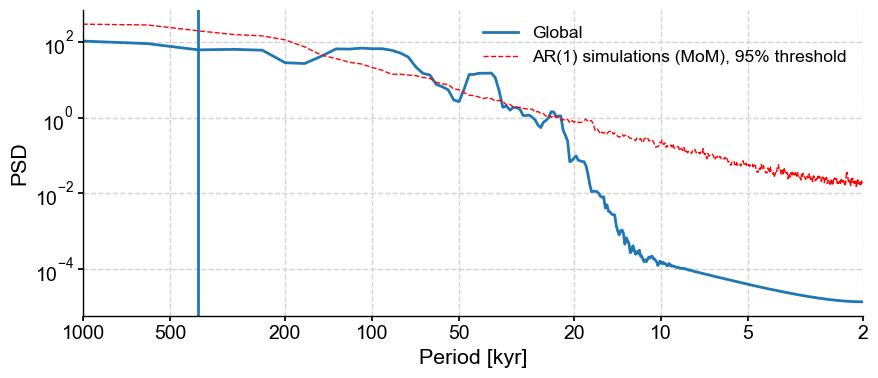

In [92]:
fig,ax=plt.subplots(figsize=(9,4))
psd_signif_cts.plot(ax=ax)
ax.axvline(400)
plt.tight_layout()

## Green Bands

### U1474

In [93]:
filt_gtsU1474=gtsU1474.standardize()
psd_gtsU1474=filt_gtsU1474.spectral(method='lomb_scargle')
psd_signif_gtsU1474=psd_gtsU1474.signif_test(qs=[0.99],number=1000)

Performing spectral analysis on individual series: 100%|█| 1000/1000 [01:49<00:0


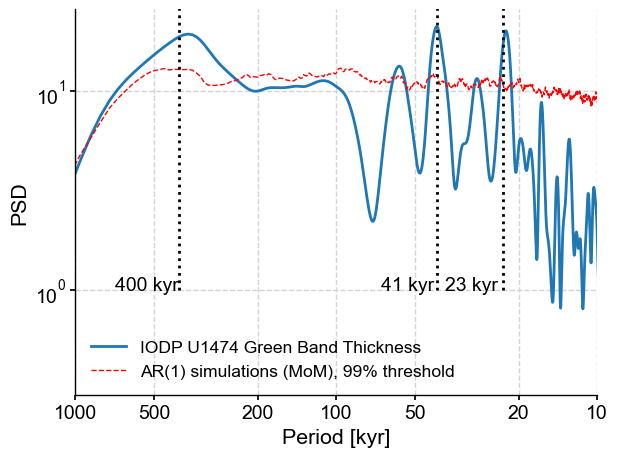

In [94]:
fig,ax=plt.subplots()
psd_signif_gtsU1474.plot(ax=ax)
ax.vlines([23,41,400],ymin=1,ymax=100,color='k',ls=':',lw=2)
ax.set_xlim(1000,10)
for i in [23,41,400]:
    ax.annotate(str(i)+' kyr',xy=(i+np.log10(10),1),xycoords='data',ha='right')
plt.tight_layout()

## Red Intervals (n)

In [95]:
reds=saps_all[(saps_all['Type']=='RED INTERVALS')].copy().set_index('Age (kyr)').sort_index()

In [96]:
bin_edges=np.arange(0,2000+step,step,dtype=int)

In [97]:
reds_records=pd.DataFrame(0.0,index=bin_edges,columns=['n'])
reds_records.loc[reds.index,'n']=1

In [101]:
rts = pyleo.Series(time=reds_records.index,value=reds_records['n'],
                    time_name='Age',time_unit='kyr BP',value_name='red intervals',value_unit='n',
                    label='ODP 964, 966, 967, 968 Red Intervals')

Time axis values sorted in ascending order


In [102]:
filt_rts=rts.standardize()
psd_rts=filt_rts.spectral(method='lomb_scargle')
psd_signif_rts=psd_rts.signif_test(qs=[0.9],number=1000)

Performing spectral analysis on individual series: 100%|█| 1000/1000 [05:01<00:0


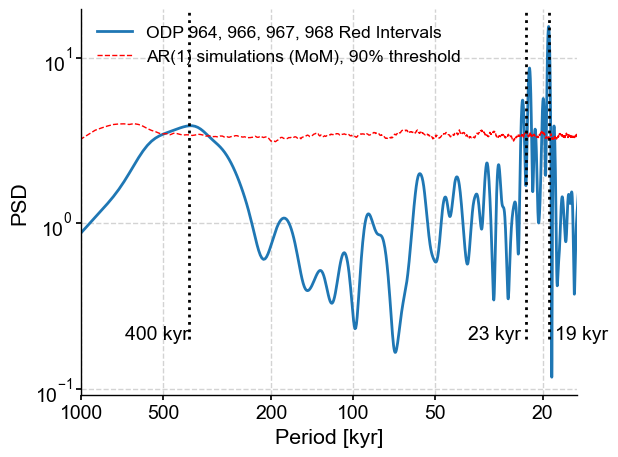

In [107]:
fig,ax=plt.subplots()
psd_signif_rts.plot(ax=ax)
ax.vlines([19,23,400],ymin=.2,ymax=100,color='k',ls=':')
ax.set_xlim(1000,15)
for i in [23,400]:
    ax.annotate(str(i)+' kyr',xy=(i+np.log10(10),.2),xycoords='data',ha='right')
ax.annotate(str(19)+' kyr',xy=(19-np.log10(10),.2),xycoords='data',ha='left')

plt.tight_layout()

## Scalograms

In [47]:
scal=filt_gtsU1474.wavelet(method='cwt')

In [48]:
scal_signif=scal.signif_test(method='ar1asym',qs=[.9])

Significance threshold 0.95 not found in qs. Picking the closest, which is 0.90


Text(-0.05, -0.05, 'C')

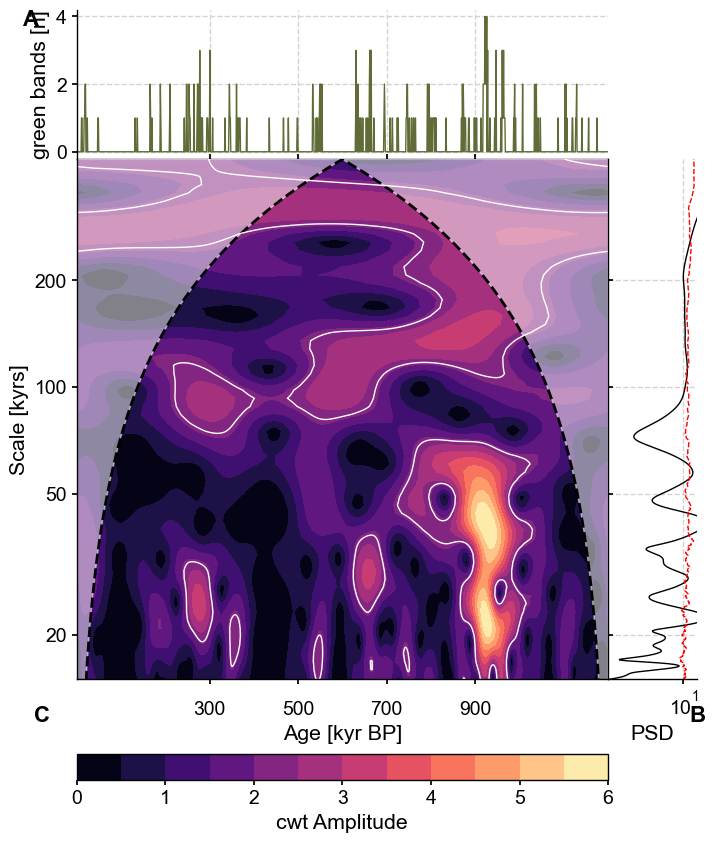

In [49]:
fig,ax=gtsU1474.summary_plot(psd=psd_signif_gtsU1474,scalogram=scal_signif,
                             period_lim=(15,440),psd_lim=(1.01,15),
                             psd_label='PSD',
                          ts_plot_kwargs={'linewidth':1,'legend':False,'color':'#606C38'},
                          psd_plot_kwargs={'color':'k','linewidth':1})
ax['ts'].annotate('A',xy=(-.07,1),ha='right',va='top',xycoords='axes fraction',fontsize=16,fontweight='bold')
ax['psd'].annotate('B',xy=(1.1,-.05),ha='right',va='top',xycoords='axes fraction',fontsize=16,fontweight='bold')
ax['scal'].annotate('C',xy=(-.05,-.05),ha='right',va='top',xycoords='axes fraction',fontsize=16,fontweight='bold')
# fig.savefig(figure_path+'spectral.png',dpi=300)

### U1313

In [50]:
filt_gtsU1313=gtsU1313.standardize()
psd_gtsU1313=filt_gtsU1313.spectral(method='lomb_scargle')
psd_signif_gtsU1313=psd_gtsU1313.signif_test(qs=[0.95],number=200)

Performing spectral analysis on individual series: 100%|█| 200/200 [00:21<00:00,


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyr]', ylabel='PSD'>)

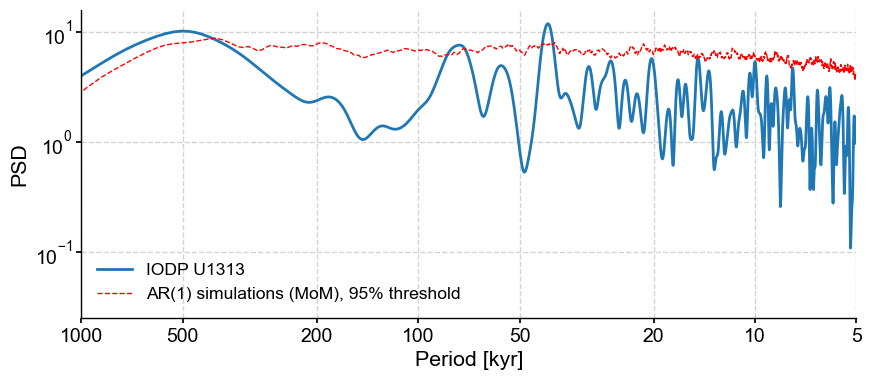

In [51]:
psd_signif_gtsU1313.plot()

In [320]:
# scal=filt_gtsU1313.wavelet(method='cwt')
scal_signif=scal.signif_test(method='ar1asym',qs=[.9])

Significance threshold 0.95 not found in qs. Picking the closest, which is 0.90


Text(-0.05, -0.05, 'C')

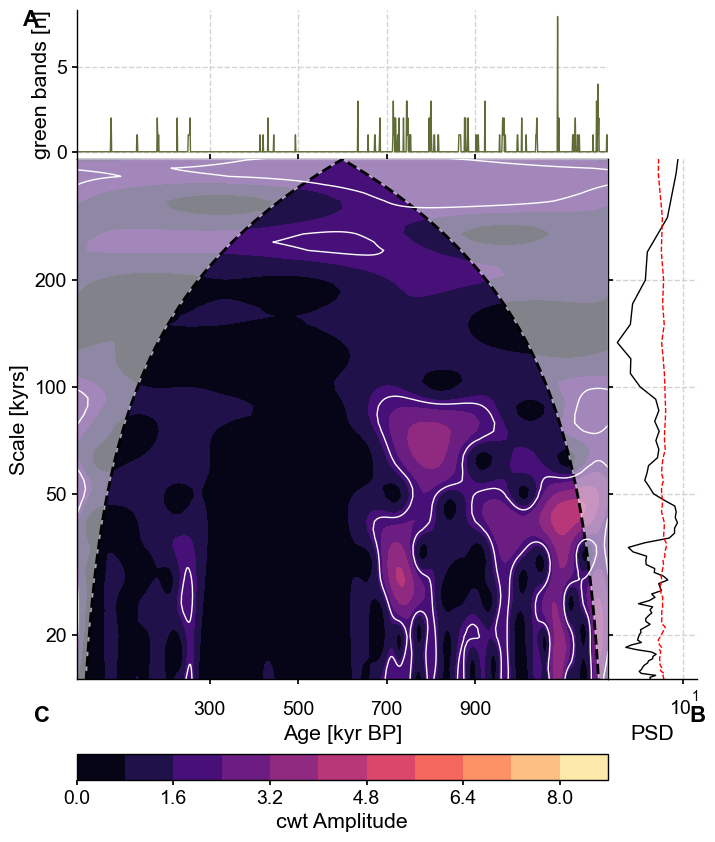

In [321]:
fig,ax=gtsU1313.summary_plot(psd=psd_signif_gtsU1313,scalogram=scal_signif,
                             period_lim=(15,440),psd_lim=(1.01,15),
                             psd_label='PSD',
                          ts_plot_kwargs={'linewidth':1,'legend':False,'color':'#606C38'},
                          psd_plot_kwargs={'color':'k','linewidth':1})
ax['ts'].annotate('A',xy=(-.07,1),ha='right',va='top',xycoords='axes fraction',fontsize=16,fontweight='bold')
ax['psd'].annotate('B',xy=(1.1,-.05),ha='right',va='top',xycoords='axes fraction',fontsize=16,fontweight='bold')
ax['scal'].annotate('C',xy=(-.05,-.05),ha='right',va='top',xycoords='axes fraction',fontsize=16,fontweight='bold')
# fig.savefig(figure_path+'spectral.png',dpi=300)

### Both

In [362]:
filt_gts=gts.standardize()
psd_gts=filt_gts.spectral(method='lomb_scargle')
psd_signif_gts=psd_gts.signif_test(qs=[0.9],number=200)
scal=filt_gts.wavelet(method='wwz')

Performing spectral analysis on individual series: 100%|█| 200/200 [00:00<00:00,


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyr]', ylabel='PSD'>)

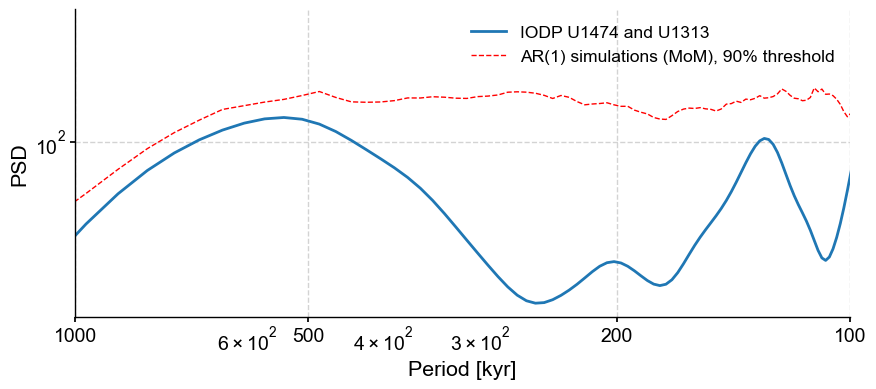

In [363]:
psd_signif_gts.plot()

In [366]:
scal_signif=scal.tc_wave_signif(method='ar1asym',qs=[.9])

AttributeError: 'Scalogram' object has no attribute 'tc_wave_signif'